In [24]:
import os
import json
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

# Sınıf isimleri (COCO formatındaki id'lerden elde edilen isimler)
CLASS_NAMES = ["Fruits", "Apple", "Banana", "Grapes", "Kiwi", "Mango", "Orange", "Pineapple", "Sugerapple", "Watermelon"]

# Modeli yükleme
model_path = "unet_fruits_segmentation.pth"
model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=10, activation=None)
model.load_state_dict(torch.load(model_path))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [68]:
# Dönüşümler
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

def predict_image(image_path):
    # Görüntüyü yükleme
    image = Image.open(image_path).convert("RGB")
    original_size = image.size
    image_np = np.array(image)

    # Dönüşümleri uygulama
    transformed = transform(image=image_np)
    image_tensor = transformed["image"].unsqueeze(0).to(device)

    # Modelle tahmin yapma
    with torch.no_grad():
        output = model(image_tensor)
        output = torch.sigmoid(output)
        output = (output > 0.5).float()
    
    output = output.cpu().numpy().squeeze()

    # Maskeleri orijinal boyutlara geri döndürme
    pred_masks_resized = [Image.fromarray(output[i].astype(np.uint8)).resize(original_size, Image.NEAREST) for i in range(output.shape[0])]

    # Görselleştirme
    fig, ax = plt.subplots(1, len(CLASS_NAMES), figsize=(15, 5))
    for i, class_name in enumerate(CLASS_NAMES):
        ax[i].imshow(image_np)
        ax[i].imshow(pred_masks_resized[i], cmap='jet', alpha=0.7)
        ax[i].set_title(class_name)
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()
    
    return CLASS_NAMES[np.argmax(np.sum(output[1:], axis=(1, 2)))+1]

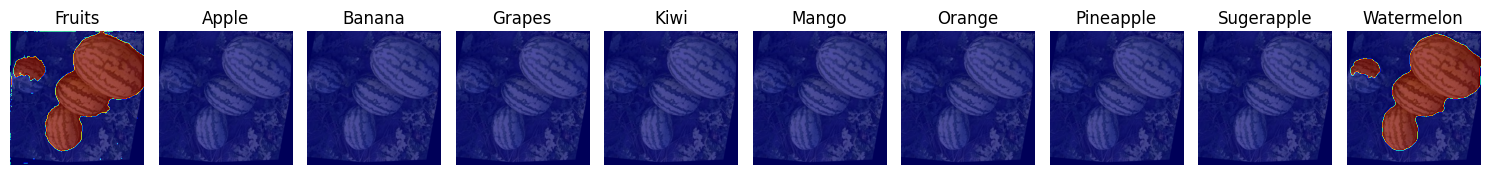

Predicted Class: Watermelon


In [69]:
# Yüklediğiniz görüntüyü tahmin etme
image_path = "Fruits-by-YOLO-1/train/images-2023-02-07T160000-797_jpeg.rf.32ec951f92dc045b932e037783fc77ba.jpg"  # Buraya test etmek istediğiniz görüntünün yolunu yazın
predicted_class = predict_image(image_path)
print(f"Predicted Class: {predicted_class}")